In [1]:
IDENTIFIER = "beethoven-op67"
NUM = 4

picklePath = f"../Pickles/{IDENTIFIER}/{IDENTIFIER}_"
numPath = f"../Pickles/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"
dataPath = f"../Data/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"

import pandas as pd
import json
import networkx as nx
import numpy as np
import itertools as iter
import matplotlib.pyplot as plt
from dwave.system import DWaveSampler, FixedEmbeddingComposite

from qubo import createBQM
from samples import duplicates, overlaps
from plots import plotLagrange


phrases = pd.read_csv(picklePath + "phrases.csv", index_col=[0,1])
G = nx.read_graphml(picklePath + "graph.graphml")
instruments = json.load(open(numPath + "instruments.json"))
embedding = json.load(open(numPath + "embedding.json", "r"))

sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)

## Pegasus topology

- Each qubit coupled to 15 other qubits
- 5640 qubits in one QPU

Due to limitations with QPU size could only pick shortish pieces/cut pieces short.

In [33]:
# Node constraint

multipliers = iter.product(np.arange(1,13,1), np.arange(11,13,1))
reads = 500

file = pd.DataFrame()

for n, e in multipliers:
    bqm = createBQM(G, phrases, instruments, n, e)
    sampleset = sampler.sample(bqm, num_reads=reads, label=f"{IDENTIFIER}_{NUM}_{reads}")
    sample = sampleset.first

    new_row = pd.DataFrame({
        "Node multiplier": [n],
        "Edge multiplier": [e],
        "Lowest energy": [bqm.energy(sample.sample)],
        "Chain break fraction": [sample.chain_break_fraction],
        "Duplicates": [duplicates(sample.sample, G)],
        "Overlaps": [overlaps(sample.sample, G)]
        })
    
    file = pd.concat([file, new_row])
    
    print(f"Recorded node multiplier {n} and edge multiplier {e}!")

file.to_csv(dataPath+"lagrange.csv", index=False, mode="a", header=False)

Recorded node multiplier 1 and edge multiplier 11!
Recorded node multiplier 1 and edge multiplier 12!
Recorded node multiplier 2 and edge multiplier 11!
Recorded node multiplier 2 and edge multiplier 12!
Recorded node multiplier 3 and edge multiplier 11!
Recorded node multiplier 3 and edge multiplier 12!
Recorded node multiplier 4 and edge multiplier 11!
Recorded node multiplier 4 and edge multiplier 12!
Recorded node multiplier 5 and edge multiplier 11!
Recorded node multiplier 5 and edge multiplier 12!
Recorded node multiplier 6 and edge multiplier 11!
Recorded node multiplier 6 and edge multiplier 12!
Recorded node multiplier 7 and edge multiplier 11!
Recorded node multiplier 7 and edge multiplier 12!
Recorded node multiplier 8 and edge multiplier 11!
Recorded node multiplier 8 and edge multiplier 12!
Recorded node multiplier 9 and edge multiplier 11!
Recorded node multiplier 9 and edge multiplier 12!
Recorded node multiplier 10 and edge multiplier 11!
Recorded node multiplier 10 an

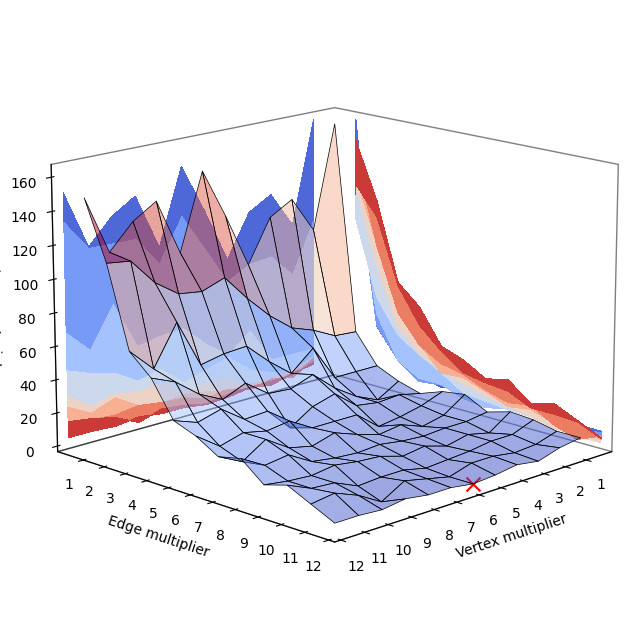

In [73]:
def plotLagrange(df: pd.DataFrame) -> None:
    '''
    Plots a parametric plot of the two variable Lagrange parameters.
    '''

    grouped = (
        df.groupby(["Node multiplier", "Edge multiplier"])
        .mean(numeric_only=True)
        .reset_index()
    )

    grouped["Broken"] = grouped["Overlaps"] + grouped["Duplicates"]

    x = grouped["Node multiplier"].unique()
    y = grouped["Edge multiplier"].unique()

    X, Y = np.meshgrid(x, y)
    Z = grouped.pivot(index="Edge multiplier", columns="Node multiplier", values="Broken").values

    plt.figure(figsize=(8,8))
    ax = plt.axes(projection ='3d')

    ax.plot_surface(X, Y, Z, cmap="coolwarm", edgecolor='black', lw=.5, alpha=.5)
    ax.grid(False)
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.view_init(elev=15, azim=45)

    ax.set(xlim=(0, x.max()), ylim=(0, y.max()), zlim=(0, Z.max()),
       xlabel="Vertex multiplier", ylabel="Edge multiplier", zlabel="Broken constraints",
       xticks=x, yticks=y)

    ax.contourf(X, Y, Z, zdir='x', offset=0, cmap='coolwarm')
    ax.contourf(X, Y, Z, zdir='y', offset=0, cmap='coolwarm')

    point_x = 6
    point_y = 12
    point_z = grouped.loc[(grouped["Node multiplier"] == point_x) & (grouped["Edge multiplier"] == point_y), "Broken"].values[0]

    ax.scatter(point_x, point_y, point_z, color='red', s=100, marker="x") # Mark position
    #ax.scatter([point_x, 0], [0, point_y], [point_z, point_z], color='red', s=100)

df = pd.read_csv(dataPath + "lagrange.csv")
plotLagrange(df)

`haydn-op1`: VM = 6, EM = 6

`beethoven-op67`: VM = 6, EM = 12